In [1]:
# Load packages and functions
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import rbf_kernel as rbf
from math import sqrt
from joblib import Parallel, delayed
import psutil
import math
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
import scipy.sparse
import warnings
import networkx as nx
import multiprocessing
import pylab
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle
from joblib import Parallel, delayed
import psutil
import math
#import scikit.sparse as cholmod


#from parallel.backends import BackendDummy as Backend
#backend = Backend()
#################
with open('inv_Us.txt','rb') as f:
    inv_us = pickle.load(f)

with open('did_rain_01.txt','rb') as f:
    did_rain_01 = pickle.load(f)

with open('g2_us.txt','rb') as f:
    g2_us = pickle.load(f)

with open('dist_mat.txt','rb') as f:
    dist_mat = pickle.load(f)

with open('loc_4087.txt','rb') as f:
    loc_4087 = pickle.load(f)

with open('g_4087_data.txt','rb') as f:
    g_4087_data = pickle.load(f)
# Functions

#F_inverse

def g_Finv(day_id,loc_id,u):
    if 1-g_4087_data[day_id][4][loc_id]>=u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=g_4087_data[day_id][1][loc_id]*g_4087_data[day_id][0][loc_id],a=1/g_4087_data[day_id][1][loc_id]).ppf((u-1+g_4087_data[day_id][4][loc_id])/g_4087_data[day_id][4][loc_id])

# Now:  0: mu , 1: disp , 2: did_rain , 3: obs_rin , 4: p , 5: [lat,lon]
# [day][param][loc_4087]


# MC estimate - Correct and working

def mc_cdf(rvs,cov_matrix,ppf_us):
    '''
    rvs: [[set1], ... , [set m]] each set of length = #locations = n.
    cov_matrix: covariance matrix between the locations in question.
    ppf_us: [u1, ... , un] length = # locs.
    '''    
    # rvs are mean 0 already, but need different covariance
    cholesk_mat = np.linalg.cholesky(cov_matrix)
    normcov_vars = [np.asarray(cholesk_mat@rvs[i]) for i in range(len(rvs))]
    out = max(1e-13,np.sum([np.sum([normcov_vars[m][n]<ppf_us[n] for n in range(len(ppf_us))])==len(ppf_us) for m in range(len(normcov_vars))]))
    return out/len(rvs)       

# New cdf calculation - correct and working
def mvn_cdf(a,b,Sigma):
    m = len(a)
    # Reorder Sigma, a and b according to the length of interval (higher earlier)
    len_interval = np.zeros(m)
    for ind in range(m):
        if a[ind] == -np.inf:
            a[ind] = -100000
        if b[ind] == np.inf:
            b[ind] = 100000
        len_interval[ind] = b[ind] - a[ind]
    order_len_interval = [int(i[0]) for i in sorted(enumerate(len_interval), key=lambda x:x[1], reverse=True)]
    Sigma = Sigma[order_len_interval, :][:,order_len_interval]
    a = [a[x] for x in order_len_interval]
    b = [b[x] for x in order_len_interval]


    d = np.zeros(shape=(m,))
    e = np.ones(shape=(m,))
    f = np.zeros(shape=(m,))
    y = np.zeros(shape=(m,))
    # these can be changed for different precision levels
    epsilon = 1.e-5
    alpha = 2.5
    N_max = int(1e5)

    # Compute Cholesky decomposition of Sigma to produce lower trinagualr matrix
    C = np.linalg.cholesky(Sigma)

    #Sigma_sparse = sparse.csc_matrix(Sigma)
    #C_sparse = cholmod.cholesky(Sigma_sparse).L()
    #C = C_sparse

    Intsum, N, Varsum = 0, 0, 0

    if a[0] != -np.inf:
        d[0] = scs.norm.cdf(a[0]/C[0,0])
    if b[0] != np.inf:
        e[0] = scs.norm.cdf(b[0]/C[0,0])
    f[0] = np.log(e[0] - d[0])

    for ind_N in range(N_max):
        
        w = np.random.rand(m)
        for ind_m in range(1,m):
            y[ind_m-1] = scs.norm.ppf(d[ind_m-1]+w[ind_m-1]*(e[ind_m-1]-d[ind_m-1]))
            if a[ind_m] != -np.inf:
                d[ind_m] = scs.norm.cdf((a[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            if b[ind_m] != np.inf:
                e[ind_m] = scs.norm.cdf((b[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            f[ind_m] = np.log((e[ind_m] - d[ind_m])) + f[ind_m-1]
        N = N+1
        delta = (f[-1]-Intsum)/N
        Intsum = Intsum + delta
        Varsum = (N-2)*Varsum/N + pow(delta, 2)
        Error = alpha*np.sqrt(Varsum)
        if Error < epsilon:
            break

    return(Intsum)
# Truncated Gaussian copula class
class truncgauss():
    def __init__(self,L):
        '''
        Class to fit and work with a truncated Gaussian copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.L=L
    
    def sim(self,theta,inv_us,draws,day_idx):
        '''
        Simulates m draws from the truncated gaussian copula conditional on parameters theta for the covariance kernel.
        '''
        # Generate mvn with Sigma, then truncate according to p_i
        n = len(self.L)
        cov_mat = rbf(self.L,gamma=theta)
        rvs = scs.multivariate_normal.rvs(np.zeros(n),cov_mat,size=draws)

        return [[ scs.norm.cdf(max([rvs[i][j],-inv_us[day_idx][j]])) for j in range(n)] for i in range(draws)]

    def nll(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                   
                    # compute and add the elegant cdf
                    if len(submat22)==1:
                        nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11)),cov=(submat11-submat12*np.linalg.inv(submat22)[0]*submat21))
                    else:
                        nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11)),cov=(submat11-submat12@np.linalg.inv(submat22)@submat21))
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_mc(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    #### MC estimate part      ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_new(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                     # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    
                    #### New estimate part      ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do new approximation to cdf
                    test = [c_dry,[Invcdf_Us[day][k] for k in c_dry],sub_cov]
                    nll += mvn_cdf([-np.inf for i in range(len(c_dry))],[Invcdf_Us[day][k] for k in c_dry],sub_cov)                               

                    #### New estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

#function for single nll eval   

def nll_sub_days(days_list,Invcdf_Us,truncation_pi,did_rain,len_locs,cov_mat):
    nll = 0
    for day in tqdm(days_list): #eg [251,...,500]
            
        # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
        if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
            nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
        else: # some dry -> use elegant cdf
            #print('elegant'+str(np.sum(did_rain[day])))
            if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

            else:
                
                # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                
                    # create submatricies
                submat11 = cov_mat[r_dry,c_dry]
                submat12 = cov_mat[r_dry,c_rain]
                submat21 = cov_mat[r_rain,c_dry]
                submat22 = cov_mat[r_rain,c_rain]
                
                #### New estimate part      ####

                if len(submat22)!=1:
                    sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                else: # submat22 is an integer, aka only one non-zero obs
                    sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                
                # Do new approximation to cdf
                plt.matshow(sub_cov)
                print(sub_cov.min())
                print(sub_cov.max())
                test = [c_dry,[Invcdf_Us[day][k] for k in c_dry],sub_cov]
                print(mvn_cdf([-np.inf for i in range(len(c_dry))],[Invcdf_Us[day][k] for k in c_dry],sub_cov))
                nll += mvn_cdf([-np.inf for i in range(len(c_dry))],[Invcdf_Us[day][k] for k in c_dry],sub_cov)                             

                #### New estimate part - end ####


                # compute and add the elegant cdf
                #if len(submat22.todense())==1:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                #else:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
        
        # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
        for loc in range(len(Invcdf_Us[0])):
            if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
            else:# dry: add cdf(invcdf(pi))
                nll -= np.log(truncation_pi[day][loc])
        
    return [-nll,test]




In [2]:
# Load gamma model

model_version = 7
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale" #(Keep this fixed)

# Run this to get the prediction data in a variable named city_data
# Getting data
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
print([path_,ckpt_path])
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

test_output = pickle.load( open(os.path.join(path_,"test_output_2014_2019-07.pkl"),"rb") )
#########

# create list of locations
loc_lat_lon = list(test_output.keys())
output_keys = ['pred_mu', 'pred_disp', 'target_did_rain', 'target_rain_value', 'date', 'pred_p']

#'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
loc_lat_lon.remove('lat_50.95_49.35_lon_-4.55_-2.95')

#########

# create list of idexes corresponding to land locations
is_loc_land = [] # boolean vector indicating for each location if it is land
                 #[0,1,...,0] length=#locations
                 # if it is not land, that location is getting skipped in gamma_outputs
                 # WILL NEED TO TAKE THIS INTO ACCOUNT ONCE I PLOT THE MAP
for loc in loc_lat_lon:
    for week in range(1):
        for day in range(1):
            for row in range(4):
                for column in range(4):
                    if test_output[loc]['mask'][week][day][row][column]==1:
                        is_loc_land.append(1)
                    else:
                        is_loc_land.append(0)

idx_land = []                       
for idx,b in enumerate(is_loc_land):
    if b==1:
        idx_land.append(idx)

#########

gamma_outputs = [[[],[],[],[],[],[]] for places in range(len(loc_lat_lon))] 
for location_idx in range(len(loc_lat_lon)):
    gamma_outputs[location_idx].append([float(loc_lat_lon[location_idx].split('_')[i]) for i in [1,2,4,5]])
    gamma_outputs[location_idx].append(test_output[loc_lat_lon[location_idx]]['mask'][0][0])
    for output_idx in range(6):
        for week in range(286):
            for day in range(7):
                #check for date, as date is formatted differently from the rest.
                if output_idx==4:
                    if day==0:
                        gamma_outputs[location_idx][output_idx].append(np.array(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week],dtype='datetime64[D]'))
                    else:
                        gamma_outputs[location_idx][output_idx].append('')                   
                else:
                    gamma_outputs[location_idx][output_idx].append(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week][day])


['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_7/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_7/checkpoints/epoch=12-step=25572-val_loss_loss=-0.391-val_metric_mse_rain=21.531.ckpt']


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Cleaning data into [day][param][all_4087_locs]

In [3]:
# Data and lat_lon for correct locations
g_4087_data = [[[],[],[],[],[]] for i in range(2002)]

for day in tqdm(range(2002)):
    for old_loc in range(len(gamma_outputs)):
        for param_idx,param in enumerate([0,1,2,3,5]):
            for row in range(4):
                for col in range(4):
                    if gamma_outputs[old_loc][7][row][col]==1:
                        g_4087_data[day][param_idx].append(gamma_outputs[old_loc][param][day][row][col])
                        

#Previous
# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.
#[place][parameter][day][row][column]

# Now:  0: mu , 1: disp , 2: did_rain , 3: obs_rin , 4: p , 5: [lat,lon]
# [day][param][loc_4087]

#Old:
#0:i,1:location,2:pred_mu,3:pred_disp,4:pred_p,5:target_rain_value,6:dates

loc_4087 = []

for old_loc in range(len(gamma_outputs)):
    for row in range(4):
        for col in range(4):
            if gamma_outputs[old_loc][7][row][col]==1:
                loc_4087.append([gamma_outputs[old_loc][6][1]-0.6-0.1*col,gamma_outputs[old_loc][6][2]+0.6+0.1*row])

# save
'''with open('g_4087_data.txt','wb') as f:
    pickle.dump(g_4087_data,f)
with open('loc_4087.txt','wb') as f:
    pickle.dump(loc_4087,f)'''

100%|██████████| 2002/2002 [02:33<00:00, 13.00it/s]


100%|██████████| 4087/4087 [00:32<00:00, 127.51it/s]


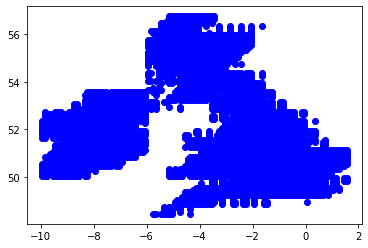

In [30]:
# draw points - lazily
for i in tqdm(loc_4087):
    plt.scatter(i[1],i[0],color='b')

### Simulating rainfall values

Take simulated us and get the ppf of the gamma mixture for them.

In [3]:
truncation_di = scs.norm.ppf(np.array(g_4087_data)[:,4,:]).squeeze()

In [4]:
truncation_di[0][:10]

array([ 0.28150862,  0.19210973,  0.43565655, -0.91330153, -0.98433429,
       -1.07097721, -1.02902746, -1.00744557, -0.94869953, -1.00035512])

(array([ 8.,  7.,  0.,  1.,  1., 11.,  9., 15., 26., 22.]),
 array([0.30029297, 0.36912889, 0.43796481, 0.50680073, 0.57563665,
        0.64447257, 0.71330849, 0.78214441, 0.85098033, 0.91981625,
        0.98865217]),
 <BarContainer object of 10 artists>)

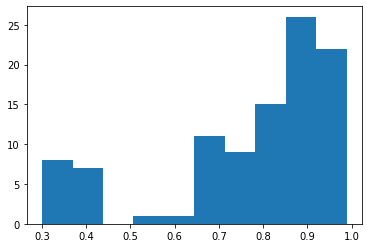

In [89]:
plt.hist(g2_us[3][:100])

### Heatmaps

In [5]:
m = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3)

m_loc_4087 = [[0,1] for i in range(len(loc_4087))]
for i in range(len(m_loc_4087)):
    m_loc_4087[i][0] = m(3,loc_4087[i][0])[1]+245000
    m_loc_4087[i][1] = m(loc_4087[i][1],3)[0]

# + +245000 IS THERE TO ALIGN MAP


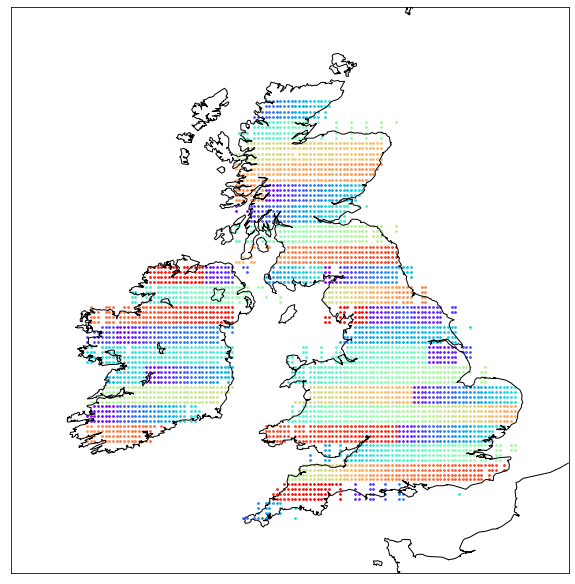

In [100]:
#locations on map 30s
fig = plt.gcf()
fig.set_size_inches(10, 20)
dpi=300

m.drawcoastlines()

color = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, 4087))
'''for loc in tqdm(range(100)):
    x,y=map(loc_4087[loc][1],loc_4087[loc][0])
    map.scatter(x,y,marker='o',color=color[loc],s=5)'''
#x,y=m(0,51)
#m.scatter(x,y,marker='o')
for i in range(4087):
    m.scatter(x=m_loc_4087[i][1],y=m_loc_4087[i][0],color=color[i],s=3)

plt.show()

In [6]:
### prepare map
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime

x11_lat=[m_loc_4087[i][1] for i in range(4087)]
y11_lon=[m_loc_4087[i][0] for i in range(4087)]
            


from scipy.interpolate import griddata
xi = np.linspace(min(x11_lat), max(x11_lat), 50)
yi = np.linspace(min(y11_lon), max(y11_lon), 50)

'''median_sim=[]
for idx,id in enumerate(range(13)):
    median_sim.append([ sorted(sim_rain11_1000[i][idx])[499] for i in range(106)])
'''

'median_sim=[]\nfor idx,id in enumerate(range(13)):\n    median_sim.append([ sorted(sim_rain11_1000[i][idx])[499] for i in range(106)])\n'

0it [00:00, ?it/s]Locator attempting to generate 3952 ticks ([0.0, ..., 23.706]), which exceeds Locator.MAXTICKS (1000).
1it [00:07,  7.37s/it]Locator attempting to generate 4081 ticks ([0.0, ..., 32.64]), which exceeds Locator.MAXTICKS (1000).
2it [00:11,  5.66s/it]Locator attempting to generate 4085 ticks ([0.0, ..., 20.42]), which exceeds Locator.MAXTICKS (1000).
3it [00:16,  5.32s/it]Locator attempting to generate 3892 ticks ([0.0, ..., 23.346]), which exceeds Locator.MAXTICKS (1000).
4it [00:21,  5.36s/it]


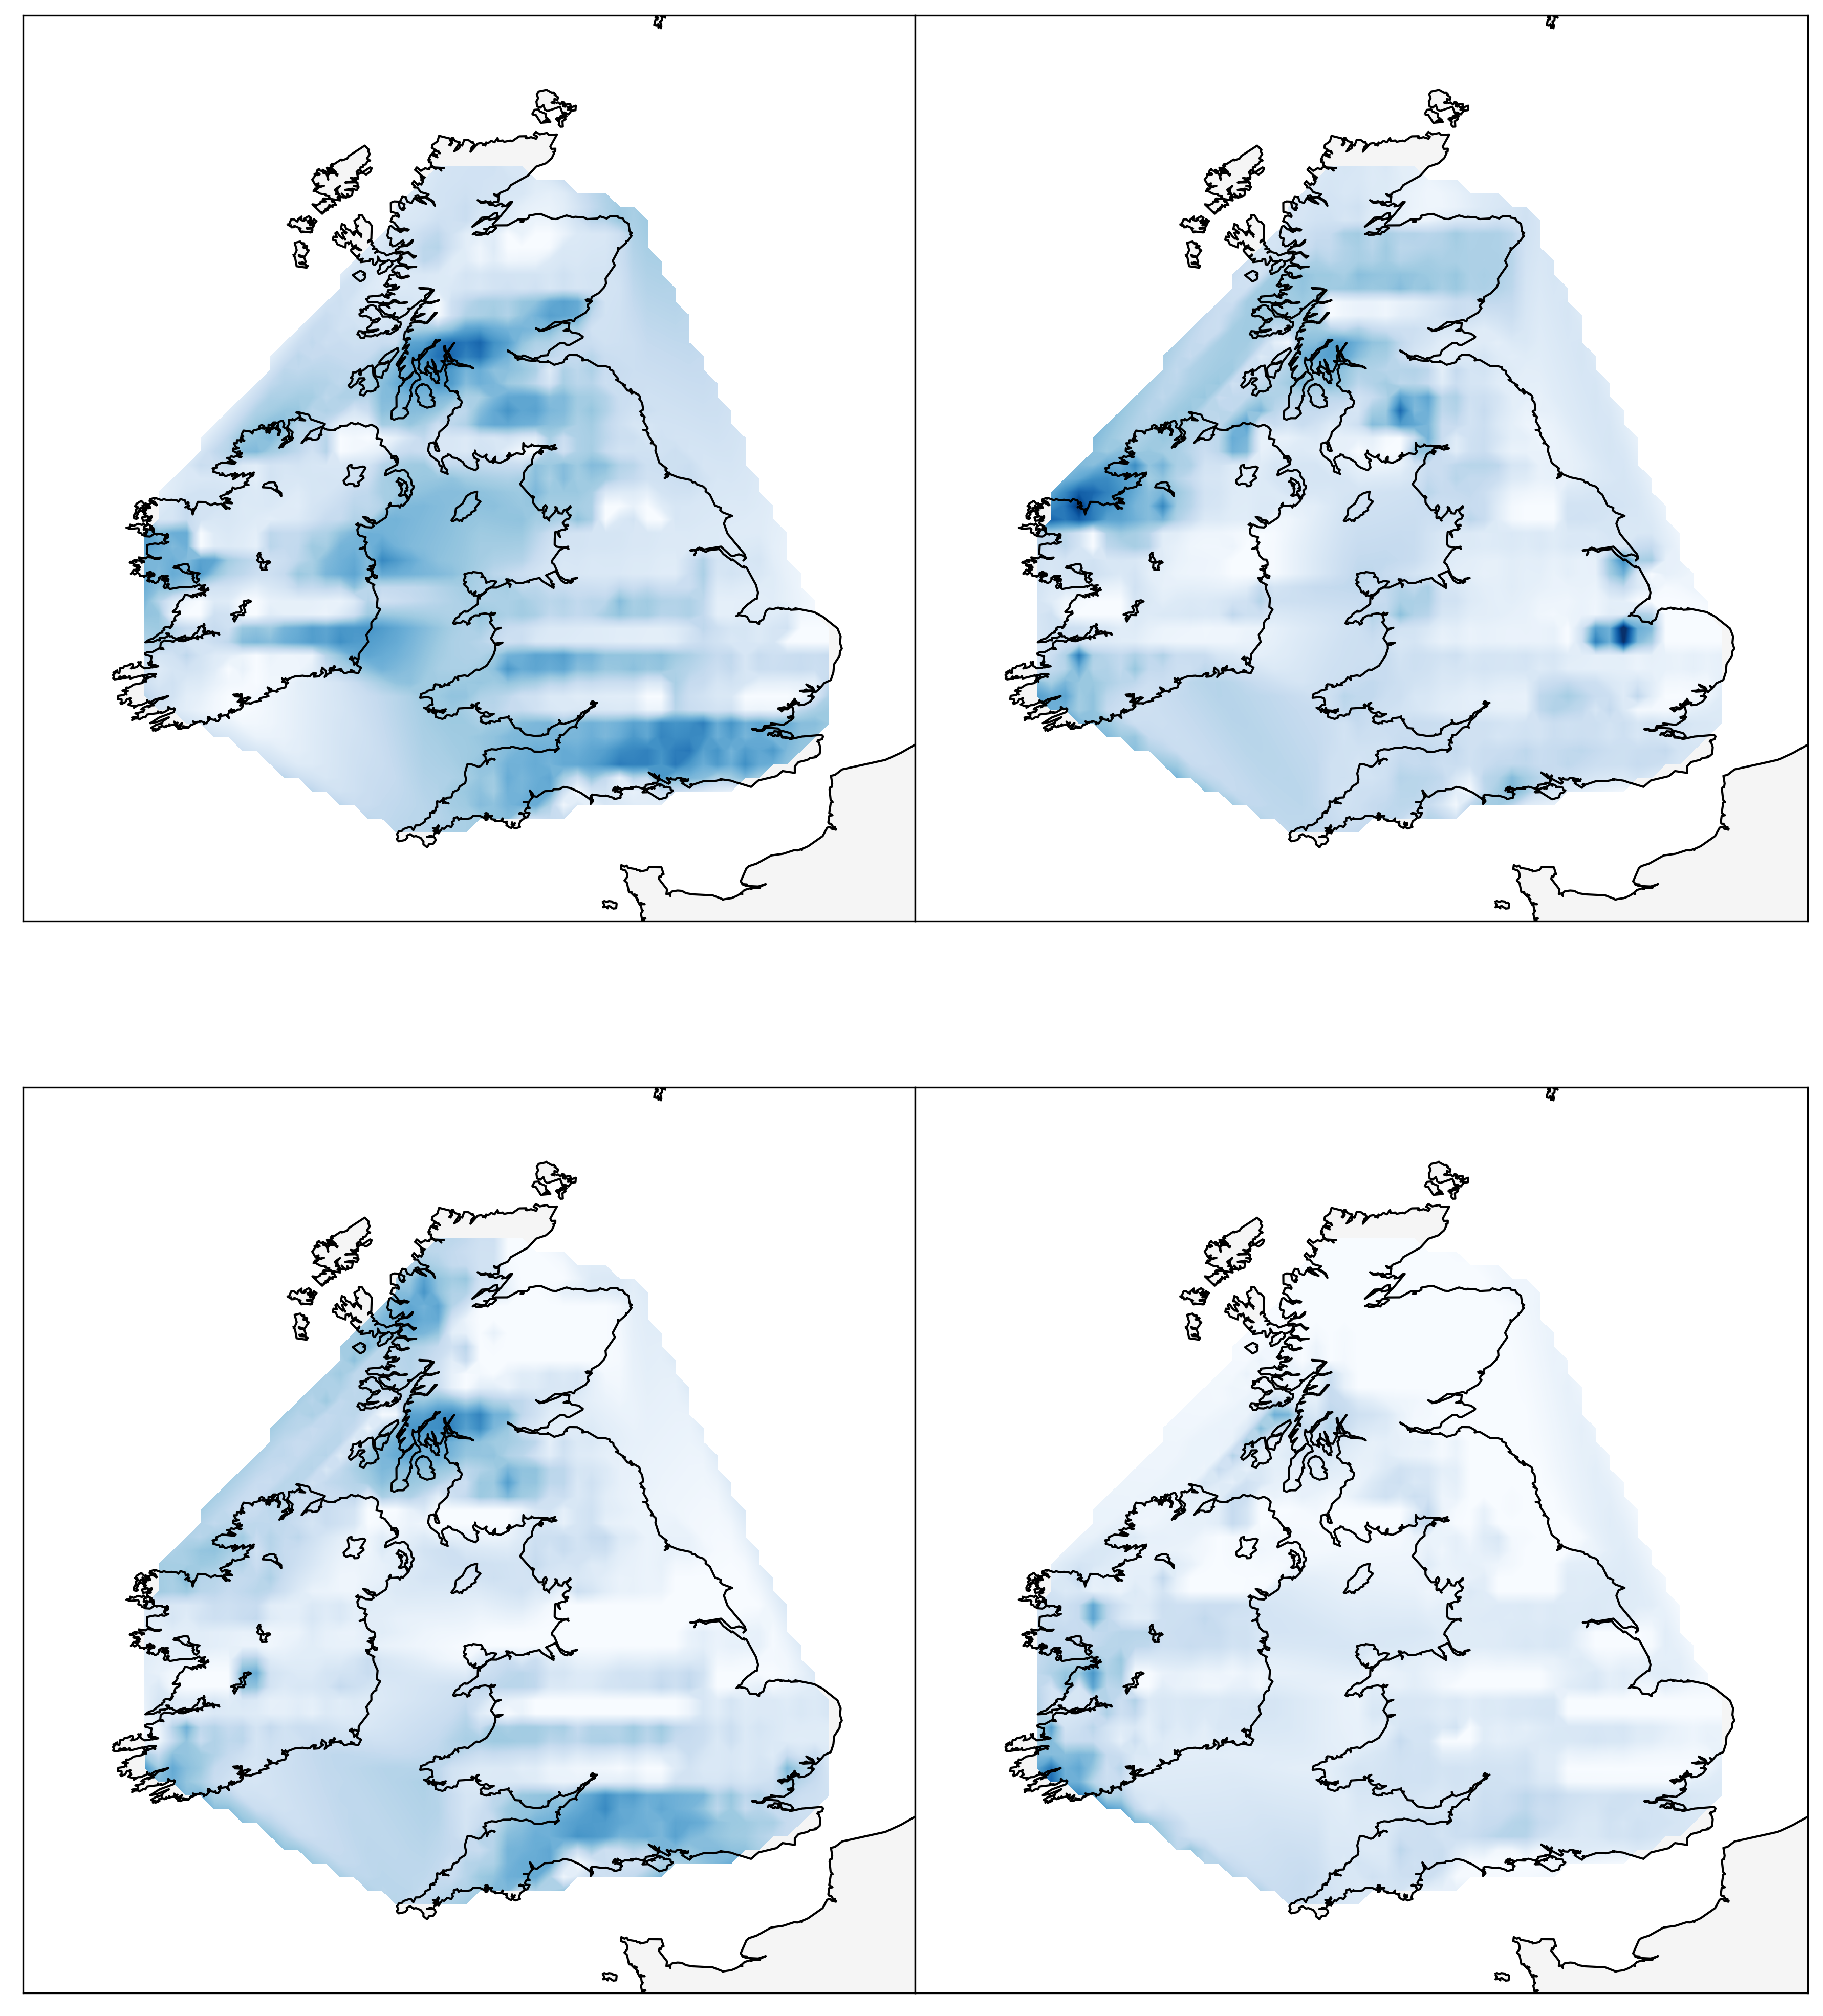

In [8]:
#plot true rain map
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True,sharey=True,figsize=(15,18.5))
for day,ax in tqdm(enumerate(axes.flat)):
    map_ax = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3,
            ax=ax)

    fig.set_dpi(300)
    map_ax.drawcoastlines()
    map_ax.fillcontinents('whitesmoke')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    
    im=ax.contourf(xi, yi, griddata((x11_lat, y11_lon),
     [g_4087_data[day][3][k] for k in range(4087)],
      (xi[None,:], yi[:,None]), method='linear'),4087,vmin=0, vmax=30,cmap='Blues')

# Now:  0: mu , 1: disp , 2: did_rain , 3: obs_rin , 4: p , 5: [lat,lon]
# [day][param][loc_4087]

#Old:
#0:i,1:location,2:pred_mu,3:pred_disp,4:pred_p,5:target_rain_value,6:dates

plt.show()

In [113]:
scs.multivariate_normal.rvs(np.zeros(3500),rbf(dist_mat,gamma=2.912)[:3500,:3500],size=1)

array([-1.23941458, -1.39638397,  2.49521741, ..., -0.22238882,
       -0.85170671, -0.38719311])

In [16]:
# simulate rain
sim_data = truncgauss(dist_mat[:3800,:3800]).sim(0.52,truncation_di,25,1080)
#self,theta,inv_us,draws,day_idx

In [17]:
sim_data2 = [[g_Finv(1080,0,sim_data[i][loc]) for loc in range(3800)] for i in tqdm(range(25))]

100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


25it [01:05,  2.61s/it]


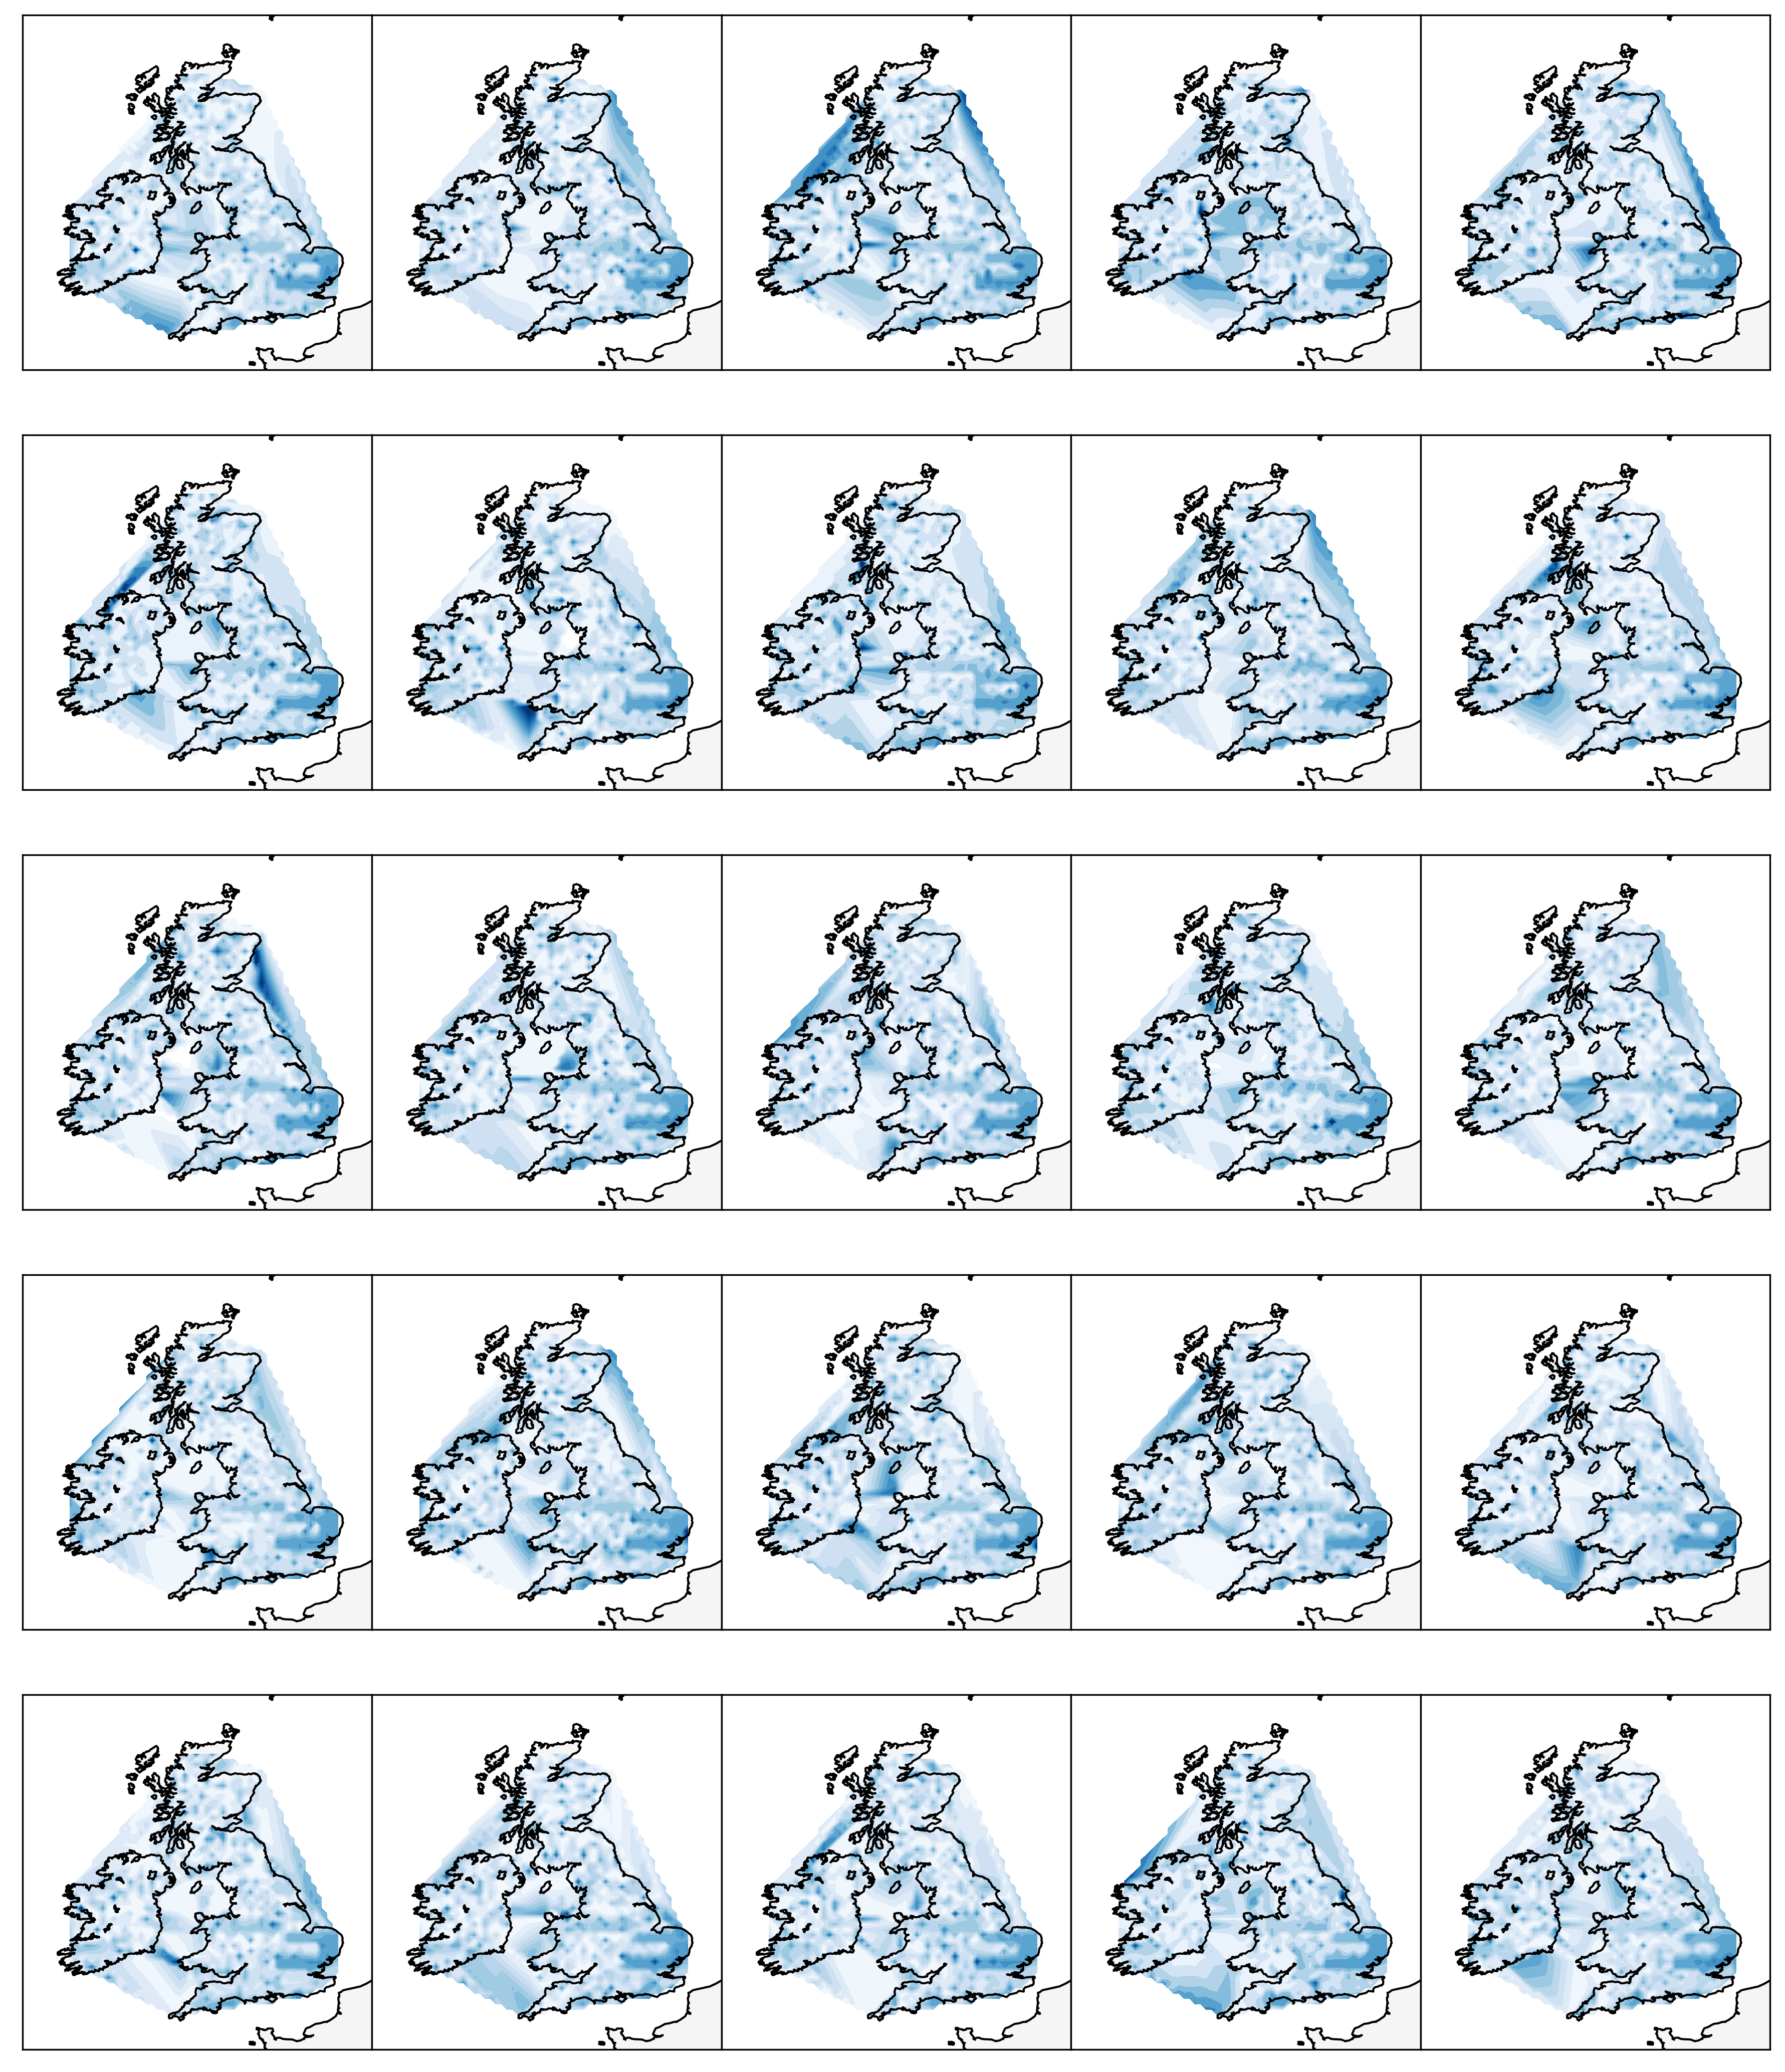

In [19]:
#plot simulated rain map
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(nrows=5, ncols=5,sharex=True,sharey=True,figsize=(15,18.5))
for day,ax in tqdm(enumerate(axes.flat)):
    map_ax = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3,
            ax=ax)
    fig.set_dpi(300)
    map_ax.drawcoastlines()
    map_ax.drawlsmask(land_color='whitesmoke')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    im=ax.contourf(xi[:3800], yi[:3800], griddata((x11_lat[:3800], y11_lon[:3800]),
     sim_data2[day],
      (xi[None,:], yi[:,None]), method='linear'),13,vmin=0, vmax=12,cmap='Blues')
    



# Now

plt.show()

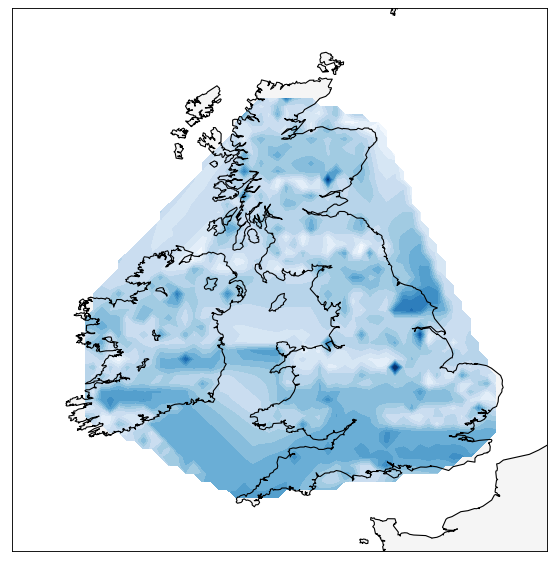

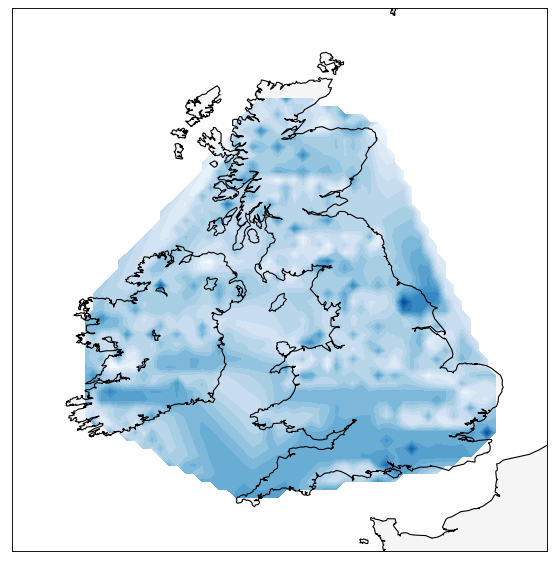

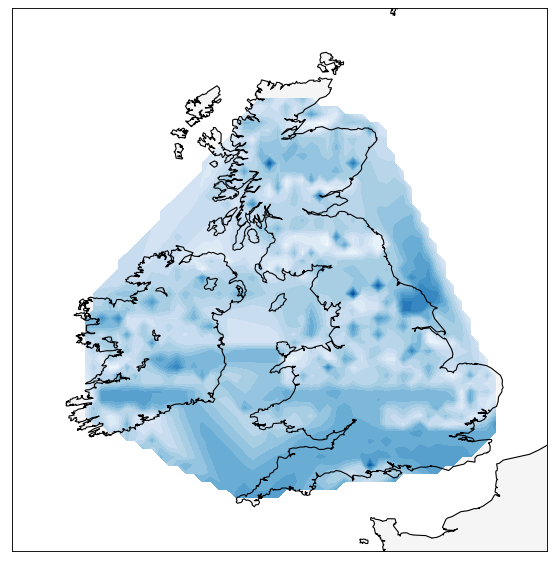

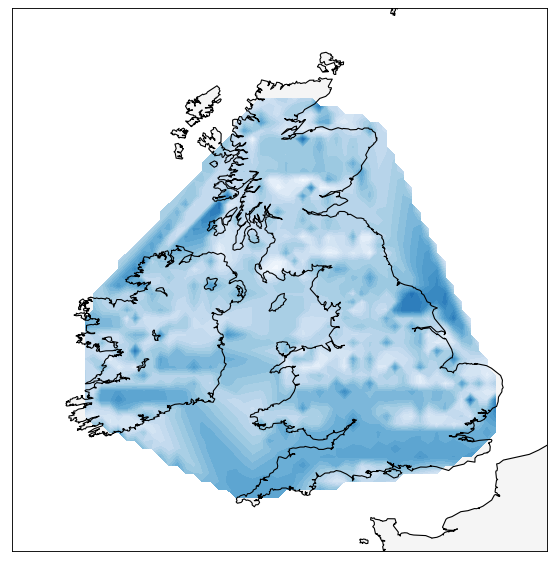

In [12]:
for draw in [22,1,20,21]:
        map_ax = Basemap(projection='mill',
                resolution='i',llcrnrlat = 49,
                llcrnrlon = -12,
                urcrnrlat = 60,
                urcrnrlon = 3)
        from matplotlib.pyplot import figure

        figure(figsize=(13, 9), dpi=80)
        fig.set_dpi(1000)
        map_ax.drawcoastlines()
        map_ax.fillcontinents('whitesmoke')


        im=plt.contourf(xi[:3800], yi[:3800], griddata((x11_lat[:3800], y11_lon[:3800]),
        sim_data2[draw],
        (xi[None,:], yi[:,None]), method='linear'),20,vmin=0, vmax=15,cmap='Blues')



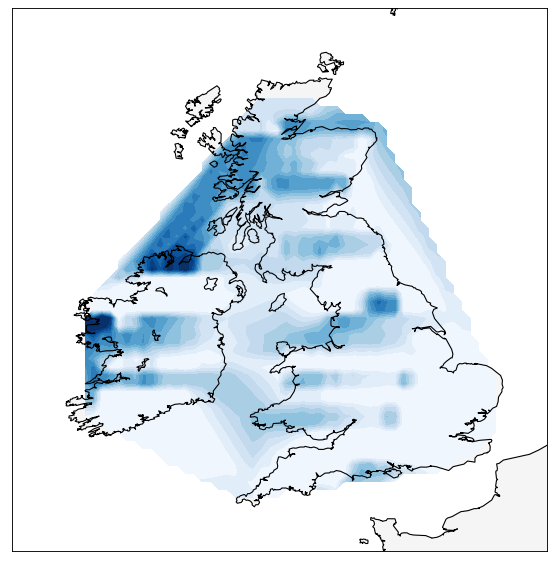

In [15]:
map_ax = Basemap(projection='mill',
        resolution='i',llcrnrlat = 49,
        llcrnrlon = -12,
        urcrnrlat = 60,
        urcrnrlon = 3)
from matplotlib.pyplot import figure
figure(figsize=(13, 9), dpi=80)
fig.set_dpi(1000)
map_ax.drawcoastlines()
map_ax.fillcontinents('whitesmoke')


im=plt.contourf(xi, yi, griddata((x11_lat, y11_lon),
[g_4087_data[1080][3][k] for k in range(4087)],
(xi[None,:], yi[:,None]), method='linear'),20,vmin=0, vmax=20,cmap='Blues')


In [4]:
# Day with almost no rain anywhere
# Now:  0: mu , 1: disp , 2: did_rain , 3: obs_rin , 4: p , 5: [lat,lon]
# [day][param][loc_4087]
map_ax = Basemap(projection='mill',
        resolution='i',llcrnrlat = 49,
        llcrnrlon = -12,
        urcrnrlat = 60,
        urcrnrlon = 3)
from matplotlib.pyplot import figure
figure(figsize=(13, 9), dpi=80)
fig.set_dpi(1000)
map_ax.drawcoastlines()
map_ax.fillcontinents('whitesmoke')


im=plt.contourf(xi, yi, griddata((x11_lat, y11_lon),
[g_4087_data[160][3][k] for k in range(4087)],
(xi[None,:], yi[:,None]), method='linear'),4087,vmin=0, vmax=30,cmap='Reds')


NameError: name 'fig' is not defined

<Figure size 1040x720 with 0 Axes>

# Slide 1
# figure from Rito
# description of data - days,predictors, prediction period - text

# Slide 2
# X tj where t in [] => model => paramteters => mixture f_i(Y_ts)
# densities for gamma and poisson

# Slide 3 Truncated gaussian copula for 0 inflated data
# sklares thm : P(y_t1, .. , y_ts) = ./.
# smoothing kernel (RBF/Matern) 
# picture of gaussian copula + picture of truncated copula (with some description of d_i)

# Slide 4 results
# realisation of copula + 3 samples 

# add more slides for - ROC, nn description, +?